<a href="https://colab.research.google.com/github/Kib3Gabriel/Intro-to-Neural-Network/blob/main/Cats_vs_Dogs_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning
We'll be using a pretrained model MobileNetV2 as the the base model. We'll freeze the base model not to make changes to the weights of any layers that are frozen during training.
We'll then train and test thr model using our dataset.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [8]:
# Load and split dataset
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [9]:
# Apply the data processing function to datasets
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [10]:
# Data Processing
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Create batches from datasets
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = validation.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [2]:
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#Create a base model from a pretrained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,   #don't include the classifier
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [3]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [11]:
for image, _ in train_batches.take(1):
  pass

feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


# Freezing the base

In [12]:
base_model.trainable = False #Won't make changes to the weights of any layers that are frozen during training

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [14]:
#Adding a classifier

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   #instead of flattening the feature map of the base
                                                                # layer we will use a  global avverage pooling layer
                                                                # that will average the entire 5*5 area of each 2D feature map and use a single 1280 element vectore per filter

In [15]:
#Add a prediction layer

prediction_layer = keras.layers.Dense(1)

In [16]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
initial_epochs = 3
validation_steps = 20
loss0, accuracy = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 2s 44ms/step - loss: 0.8440 - accuracy: 0.4406


In [24]:
#how to train our model on our images
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy']

print(acc)


Epoch 1/3
582/582 [==============================] - 41s 63ms/step - loss: 0.0754 - accuracy: 0.9717 - val_loss: 0.0485 - val_accuracy: 0.9824
Epoch 2/3
582/582 [==============================] - 41s 69ms/step - loss: 0.0441 - accuracy: 0.9833 - val_loss: 0.0463 - val_accuracy: 0.9828
Epoch 3/3
582/582 [==============================] - 40s 65ms/step - loss: 0.0400 - accuracy: 0.9850 - val_loss: 0.0542 - val_accuracy: 0.9832
[0.9716818928718567, 0.9832885265350342, 0.9850080609321594]


In [27]:
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

print('Val acc',val_acc)
print('loss',loss)
print('val loss', val_loss)

Val acc [0.9823731780052185, 0.9828031063079834, 0.9832330346107483]
loss [0.07535956054925919, 0.04414819926023483, 0.04001201316714287]
val loss [0.04846524819731712, 0.04632887989282608, 0.054183706641197205]


In [25]:
model.save("cats_vs_dogs.h5")
new_model = tf.keras.models.load_model('cats_vs_dogs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()

# Save the model.
with open('cats_vs_dogs.tflite', 'wb') as f:
  f.write(tflite_model)

In [35]:
test_loss, test_acc = model.evaluate(test_batches)

print('Test accuracy :', test_acc)

73/73 [==============================] - 5s 63ms/step - loss: 0.0467 - accuracy: 0.9845
Test accuracy : 0.9845227599143982


In [56]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate confusion matrix on test set
y_true = []
y_pred = []

for image_batch, label_batch in test_batches:
    y_true.extend(label_batch.numpy())
    predictions = new_model.predict(image_batch)
    y_pred.extend(tf.round(tf.sigmoid(predictions)).numpy().astype(int).flatten())


1/1 [==============================] - 0s 25ms/step


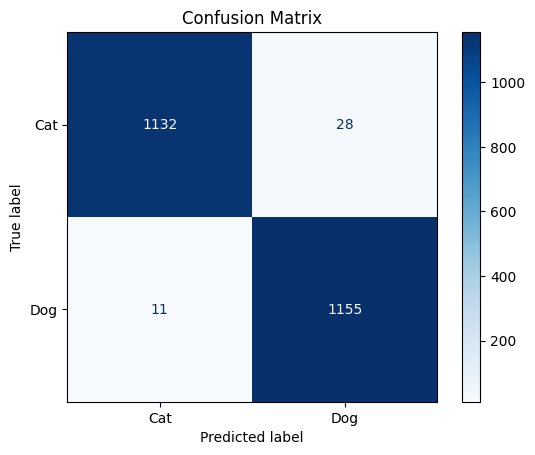

In [59]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Cat', 'Dog'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Function to preprocess an image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 127.5) - 1
    return image

In [60]:
# Function to make a prediction on a single image
def predict_image(model, image_path):
    image = preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    prediction = new_model.predict(image)
    return prediction

In [61]:
# Function to display the image and prediction result
def display_prediction(image_path, prediction):
    plt.figure(figsize=(5,7))
    plt.imshow(plt.imread(image_path))
    plt.title(f"Prediction: {'Dog' if prediction > 0 else 'Cat'}")
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 23ms/step


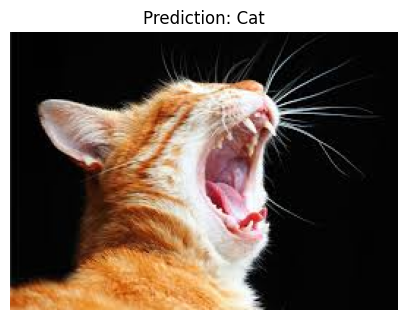

1/1 [==============================] - 0s 24ms/step


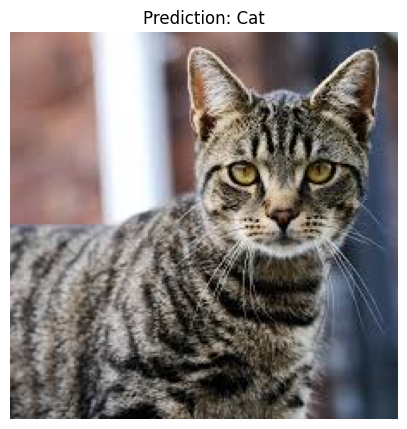

1/1 [==============================] - 0s 22ms/step


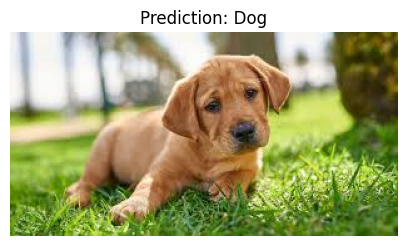

1/1 [==============================] - 0s 24ms/step


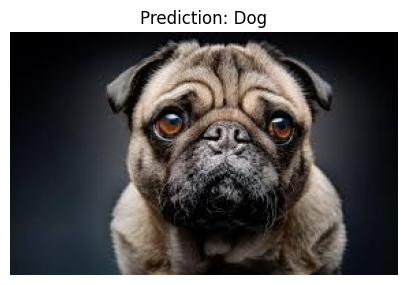

1/1 [==============================] - 0s 24ms/step


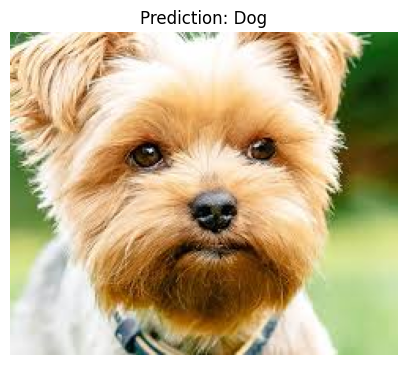

In [63]:
# Example image paths
example_image_paths = ['/content/drive/MyDrive/Colab Notebooks/cat_1.jpeg', '/content/drive/MyDrive/Colab Notebooks/cat_2.jpeg', '/content/drive/MyDrive/Colab Notebooks/dog_1.jpeg', '/content/drive/MyDrive/Colab Notebooks/dog_4.jpeg.jpeg','/content/drive/MyDrive/Colab Notebooks/dog_3.jpeg.jpeg']

# Predict and display results for each example image
for image_path in example_image_paths:
    prediction = predict_image(new_model, image_path)
    display_prediction(image_path, prediction)